# Installing required modules

In [6]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.63 s (started: 2022-12-05 00:20:18 +00:00)


In [7]:
!pip install torch_pruning==0.2.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.84 s (started: 2022-12-05 00:20:21 +00:00)


# Importing required modules

In [8]:
# Importing required modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchvision import models,transforms,datasets
import torch.nn.utils.prune as prune
from copy import deepcopy
import torch_pruning as tp
import sys
import os

# Module to time everything
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.92 ms (started: 2022-12-05 00:20:24 +00:00)


In [9]:
# Setting up GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

time: 662 ms (started: 2022-12-05 00:20:24 +00:00)


# Import CIFAR-100 and Resize

In [10]:
# Transforming the CIFAR100 train dataset and test dataset
train_transform = transforms.Compose([transforms.Resize(64),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomRotation(15),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.48,0.4593,0.4155),(0.2774,0.2794,0.2794))])

test_transform = transforms.Compose([transforms.Resize(64),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.48,0.4593,0.4155),(0.2774,0.2794,0.2794))])

time: 2.18 ms (started: 2022-12-05 00:20:24 +00:00)


In [11]:
# Loading the train dataset
train_data_set = datasets.CIFAR100(root = "CIFAR100", train = True, download = True, transform = train_transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting CIFAR100/cifar-100-python.tar.gz to CIFAR100
time: 18.9 s (started: 2022-12-05 00:20:24 +00:00)


In [12]:
# Loading the test dataset
test_data_set = datasets.CIFAR100(root = "CIFAR100", train = False, download = True, transform = test_transform)

Files already downloaded and verified
time: 794 ms (started: 2022-12-05 00:20:43 +00:00)


In [13]:
train_data_set[0][0].shape

torch.Size([3, 64, 64])

time: 84.8 ms (started: 2022-12-05 00:20:44 +00:00)


In [14]:
test_data_set[0][0].shape

torch.Size([3, 64, 64])

time: 4.2 ms (started: 2022-12-05 00:20:44 +00:00)


# VGG16

In [15]:
# Defining number of classes in the dataset
n_classes = 100

# Defining the Batch size for training
batch_size = 64

# Defining Number of epochs
n_epochs = 15

time: 600 µs (started: 2022-12-05 00:20:44 +00:00)


In [16]:
# Importing VGG16 model with 130 million+ parameters
vgg16_model = models.vgg16(pretrained = True)

# Modifying last layer out classes
vgg16_model.classifier[6].out_features = n_classes

vgg16_model = vgg16_model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

time: 10.3 s (started: 2022-12-05 00:20:44 +00:00)


In [17]:
# Printing VGG16 Model
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training

In [18]:
# To compute the cross entropy loss between input and target
criterion = nn.CrossEntropyLoss()

# To implement stochastic gradient descent and optimize the model
sgd_optimizer = optim.SGD(vgg16_model.parameters(), lr = 0.003, momentum = 0.9)

# Decays the learning rate of each parameter group by gamma every step_size epochs
lr_scheduler = optim.lr_scheduler.StepLR(sgd_optimizer, step_size = 15, gamma = 0.1)

# Defining a 'DataLoader' constructor, a Python iterable over a dataset
train_dataloader  = DataLoader(train_data_set, batch_size = batch_size, shuffle = True)
test_dataloader   = DataLoader(test_data_set, batch_size = batch_size, shuffle = True)

time: 2.86 ms (started: 2022-12-05 00:20:54 +00:00)


In [19]:
# Method to train the model
def fit(model, dataset, optimizer, scheduler, criterion):
  # Set model to training mode
  model.train()
  if scheduler != None:
    scheduler.step()
  # Iterating over the data
  for data, targets in dataset:
    data    = data.to(device)
    targets = targets.to(device)
    # Reset the gradients
    optimizer.zero_grad()
    # Generate predictions
    pred  = model(data)
    # Calculate loss
    loss  = criterion(pred, targets)
    # Backpropagation
    loss.backward()
    # Update model parameters
    optimizer.step()

time: 1.72 ms (started: 2022-12-05 00:20:54 +00:00)


In [20]:
from os import pread
# Method to validate the model
def validate(model, dataset, criterion):
  # Set model to evaluation mode
  model.eval()
  accuracy  = 0
  loss      = []
  for data, targets in dataset:
    data    = data.to(device)
    targets = targets.to(device)
    pred    = model(data)
    # Get loss
    l = criterion(pred, targets)
    loss.append(l.item())
    # Get index of class label
    _,preds = torch.max(pred.data,1)
    # Get accuracy
    accuracy += torch.sum(preds == targets).item()

  return 100*accuracy/len(dataset.dataset), np.mean(np.array(loss))

time: 2.07 ms (started: 2022-12-05 00:20:54 +00:00)


In [21]:
train_loss  = []
train_acc   = []
test_loss   = []
test_acc    = []
epochs      = []
epoch_value = 0

# Loop for n_epochs
for epoch in range(n_epochs):
  # Fit model
  fit(vgg16_model, train_dataloader, sgd_optimizer, lr_scheduler, criterion)

  # Train validation
  train_accuracy, train_lss = validate(vgg16_model, train_dataloader, criterion)
  train_loss.append(train_lss)
  train_acc.append(train_accuracy)

  # Test validation
  test_accuracy, test_lss = validate(vgg16_model, test_dataloader, criterion)
  test_loss.append(test_lss)
  test_acc.append(test_accuracy)

  # Printing the epochs with Traing Loss, Train Accuracy, Test Loss and Test Accuracy
  print(f'Epoch:{epoch+1:2.0f}\t Train_Loss:{train_loss[-1]:.4f}\t Train_Acc:{train_acc[-1]:.4f}\t Test_Loss:{test_loss[-1]:.4f}\t Test_Acc:{test_acc[-1]:.4f}')
  epoch_value +=1
  epochs.append(epoch_value)


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1	 Train_Loss:2.8910	 Train_Acc:24.5320	 Test_Loss:2.8570	 Test_Acc:25.1500
Epoch: 2	 Train_Loss:1.9007	 Train_Acc:46.2920	 Test_Loss:1.9194	 Test_Acc:45.1000
Epoch: 3	 Train_Loss:1.4763	 Train_Acc:57.9180	 Test_Loss:1.5240	 Test_Acc:56.3700
Epoch: 4	 Train_Loss:1.2635	 Train_Acc:63.5120	 Test_Loss:1.4159	 Test_Acc:60.1500
Epoch: 5	 Train_Loss:1.0431	 Train_Acc:69.5580	 Test_Loss:1.2558	 Test_Acc:64.5900
Epoch: 6	 Train_Loss:0.8838	 Train_Acc:73.6820	 Test_Loss:1.1475	 Test_Acc:67.1500
Epoch: 7	 Train_Loss:0.8522	 Train_Acc:74.4360	 Test_Loss:1.1774	 Test_Acc:67.1000
Epoch: 8	 Train_Loss:0.7457	 Train_Acc:77.2880	 Test_Loss:1.1667	 Test_Acc:67.6700
Epoch: 9	 Train_Loss:0.6765	 Train_Acc:79.4540	 Test_Loss:1.1362	 Test_Acc:69.0200
Epoch:10	 Train_Loss:0.6150	 Train_Acc:81.4380	 Test_Loss:1.1038	 Test_Acc:69.5900
Epoch:11	 Train_Loss:0.5926	 Train_Acc:81.9180	 Test_Loss:1.1445	 Test_Acc:69.8800
Epoch:12	 Train_Loss:0.5250	 Train_Acc:83.9340	 Test_Loss:1.1887	 Test_Acc:69.0500
Epoc

Test Loss:  [2.857039453117711, 1.919366712782793, 1.5239803312690394, 1.4159252753682956, 1.2558196779269322, 1.1474961027218278, 1.1773527708782512, 1.166714234336926, 1.1361630050240048, 1.1037584554617572, 1.144543244200907, 1.1886587059421905, 1.1225995501135564, 1.1952567176454385, 1.0557947656151596]
Epochs:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Text(0.5, 0, 'Test Loss')

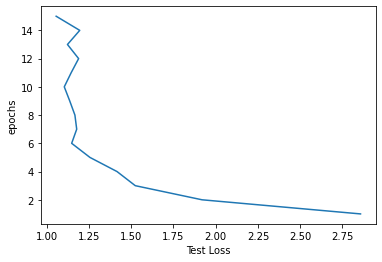

time: 153 ms (started: 2022-12-05 00:57:28 +00:00)


In [22]:
# Plotting Epoch vs Test Loss
print('Test Loss: ', test_loss)
print('Epochs: ', epochs)

plt.plot(test_loss, epochs)
plt.ylabel('epochs')
plt.xlabel('Test Loss')

# Save VGG16 Model

In [23]:
# Authorizing Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 22min 39s (started: 2022-12-05 00:57:28 +00:00)


In [24]:
# Saving the model to Drive
path = F"/content/gdrive/My Drive/Colab Notebooks/VGG16(SGD)-v1.0"
torch.save(vgg16_model.state_dict(), path)

time: 19.1 s (started: 2022-12-05 01:20:08 +00:00)


In [25]:
# Checking the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda
time: 7.7 ms (started: 2022-12-05 01:20:27 +00:00)


# Important Functions

In [26]:
# Method to remove parameters
def remove_parameters(model):
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
    return model

time: 1.11 ms (started: 2022-12-05 01:20:27 +00:00)


In [27]:
# Method for Unstructured Pruning
def unstructured_global_pruning(model, amount):
  pruning_model       = deepcopy(model)
  pruning_model       = pruning_model.to(device)
  parameters_to_prune = []
  for module_name, module in pruning_model.named_modules():
      if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
          parameters_to_prune.append((module, "weight"))

  prune.global_unstructured(
      parameters = parameters_to_prune,
      pruning_method = prune.L1Unstructured,
      amount = amount)

  pruning_model = remove_parameters(model = pruning_model)

  return pruning_model

time: 984 µs (started: 2022-12-05 01:20:27 +00:00)


In [28]:
# Method for Structured Pruning
def structured_pruning(model, sparsity_layer):
  pruning_model         = deepcopy(model)
  pruning_model         = pruning_model.to(device)
  prunable_module_type  = (nn.Conv2d, nn.Linear)
  prunable_modules      = [ m for m in pruning_model.modules() if isinstance(m, prunable_module_type) ]
  strategy              = tp.strategy.L1Strategy()
  Dependency_Graph      = tp.DependencyGraph().build_dependency(pruning_model, example_inputs = torch.randn(1,3,64,64))

  i = 0
  for layer_to_prune in prunable_modules:
    if isinstance(layer_to_prune, nn.Conv2d):
        prune_function = tp.prune_conv
    elif isinstance(layer_to_prune, nn.Linear):
        prune_function = tp.prune_linear
    
    pruning_idxs  = strategy(layer_to_prune.weight, amount = sparsity_layer[i])
    plan          = Dependency_Graph.get_pruning_plan( layer_to_prune, prune_function, pruning_idxs)

    i += 1

    plan.exec()
  
  return pruning_model

time: 1.46 ms (started: 2022-12-05 01:20:27 +00:00)


In [29]:
# Method to evaluate the loss and accuracy of the model
def evaluate(model, dataloader):
  model.eval()
  acc = 0
  loss = []
  for data, targets in dataloader:
    data = data.to(device)
    targets = targets.to(device)
    out = model(data)
    #Get loss
    l = criterion(out, targets)
    loss.append(l.item())
    #Get index of class label
    _,preds = torch.max(out.data,1)
    #Get accuracy
    acc += torch.sum(preds == targets).item()

  return 100*acc/len(dataloader.dataset), np.mean(np.array(loss))

time: 1.06 ms (started: 2022-12-05 01:20:27 +00:00)


In [30]:
# Method to measure module sparsity
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):
    n_zeros = 0
    n_elements = 0
    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                n_zeros += torch.sum(buffer == 0).item()
                n_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                n_zeros += torch.sum(buffer == 0).item()
                n_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                n_zeros += torch.sum(param == 0).item()
                n_elements += param.nelement()
            if "bias" in param_name and bias == True:
                n_zeros += torch.sum(param == 0).item()
                n_elements += param.nelement()

    sparsity = n_zeros / n_elements

    return n_zeros, n_elements, sparsity

time: 1.48 ms (started: 2022-12-05 01:20:27 +00:00)


In [31]:
# Method to measure Global sparsity
def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):

    n_zeros = 0
    n_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            n_zeros += module_num_zeros
            n_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            n_zeros += module_num_zeros
            n_elements += module_num_elements

    sparsity = n_zeros / n_elements

    return n_zeros, n_elements, sparsity

time: 1.83 ms (started: 2022-12-05 01:20:27 +00:00)


In [32]:
# Defining a 'DataLoader' constructor, a Python iterable over a dataset
train_dataloader = DataLoader(train_data_set, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data_set, batch_size = batch_size)

time: 974 µs (started: 2022-12-05 01:20:27 +00:00)


# Import Model to be Pruned

In [33]:
vgg16_model = models.vgg16(pretrained = False)
vgg16_model.classifier[6].out_features = n_classes

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


time: 1.75 s (started: 2022-12-05 01:20:27 +00:00)


In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 2.54 s (started: 2022-12-05 01:20:29 +00:00)


In [35]:
vgg16_model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/VGG16(SGD)-v1.0'))

<All keys matched successfully>

time: 912 ms (started: 2022-12-05 01:20:32 +00:00)


In [36]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vgg16_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

time: 133 ms (started: 2022-12-05 01:20:33 +00:00)


In [37]:
next(vgg16_model.parameters()).is_cuda

True

time: 4.34 ms (started: 2022-12-05 01:20:33 +00:00)


In [38]:
# Measuring Global Sparsity for VGG16 Model
num_zeros, num_elements, sparsity = measure_global_sparsity(
            vgg16_model,
            weight=True,
            bias=False,
            conv2d_use_mask=False,
            linear_use_mask=False)

print("Global Sparsity:")
print("{:.2f}".format(sparsity))

Global Sparsity:
0.00
time: 17.6 ms (started: 2022-12-05 01:20:33 +00:00)


# Iterative Pruning Iteration

# Unstructured Pruning

In [39]:
ustp_model = unstructured_global_pruning(vgg16_model, 0.8)

time: 365 ms (started: 2022-12-05 01:20:33 +00:00)


In [40]:
next(ustp_model.parameters()).is_cuda

True

time: 4.61 ms (started: 2022-12-05 01:20:33 +00:00)


In [41]:
acc, loss = evaluate(ustp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

Accuracy :  73.08 	Loss :  1.1402073308920404
time: 8.45 s (started: 2022-12-05 01:20:33 +00:00)


In [42]:
# Measuring Global Sparsity for Unstructured Pruning Model
num_zeros, num_elements, sparsity = measure_global_sparsity(
            ustp_model,
            weight  = True,
            bias    = False,
            conv2d_use_mask = False,
            linear_use_mask = False)

print("Global Sparsity:")
print("{:.2f}".format(sparsity))

Global Sparsity:
0.80
time: 18.8 ms (started: 2022-12-05 01:20:42 +00:00)


In [43]:
# Measuring Sparsity for each layer
sparsity_layer = []
i = 0
layer = []
for module_name, module in ustp_model.named_modules():
  if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
    num_zeros, num_elements, sparsity = measure_module_sparsity(module, weight=True, bias=False, use_mask=False)
    print('Layer', i , num_zeros, num_elements, sparsity)
    sparsity_layer.append(sparsity)
    layer.append(i)
    i+= 1

Layer 0 58 1728 0.03356481481481482
Layer 1 6069 36864 0.16463216145833334
Layer 2 12503 73728 0.1695827907986111
Layer 3 28989 147456 0.19659423828125
Layer 4 67658 294912 0.22941758897569445
Layer 5 164003 589824 0.2780541314019097
Layer 6 159384 589824 0.2702229817708333
Layer 7 373959 1179648 0.31700897216796875
Layer 8 931040 2359296 0.3946261935763889
Layer 9 937821 2359296 0.39750035603841144
Layer 10 898921 2359296 0.38101238674587673
Layer 11 908138 2359296 0.38491906060112846
Layer 12 996303 2359296 0.4222882588704427
Layer 13 93581452 102760448 0.9106757884122887
Layer 14 10158432 16777216 0.6054897308349609
Layer 15 1450572 4096000 0.3541435546875
time: 54 ms (started: 2022-12-05 01:20:42 +00:00)


Sparsity:  [0.03356481481481482, 0.16463216145833334, 0.1695827907986111, 0.19659423828125, 0.22941758897569445, 0.2780541314019097, 0.2702229817708333, 0.31700897216796875, 0.3946261935763889, 0.39750035603841144, 0.38101238674587673, 0.38491906060112846, 0.4222882588704427, 0.9106757884122887, 0.6054897308349609, 0.3541435546875]
Layers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Text(0.5, 0, 'Sparsity')

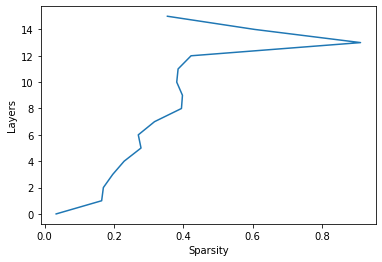

time: 140 ms (started: 2022-12-05 01:20:42 +00:00)


In [44]:
# Plotting Sparsity vs Layers
print('Sparsity: ', sparsity_layer)
print('Layers: ', layer)

plt.plot(sparsity_layer, layer)
plt.ylabel('Layers')
plt.xlabel('Sparsity')

In [45]:
sparsity_layer = [ max(round(round(i,2)-0.01,2),0) for i in sparsity_layer]
sparsity_layer

[0.02,
 0.15,
 0.16,
 0.19,
 0.22,
 0.27,
 0.26,
 0.31,
 0.38,
 0.39,
 0.37,
 0.37,
 0.41,
 0.9,
 0.6,
 0.34]

time: 5.21 ms (started: 2022-12-05 01:20:42 +00:00)


# Structured Pruning

In [46]:
stp_model = structured_pruning(ustp_model, sparsity_layer)

time: 1.18 s (started: 2022-12-05 01:20:42 +00:00)


In [47]:
tp.utils.count_params(stp_model)

13203121

time: 3.63 ms (started: 2022-12-05 01:20:43 +00:00)


In [48]:
stp_model.classifier[6].out_features = 100
print(stp_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(63, 55, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(55, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(108, 104, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(104, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(200, 187, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(187, 190, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
stp_model = stp_model.to(device)
acc, loss = evaluate(stp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

Accuracy :  7.31 	Loss :  4.481076611075432
time: 6.35 s (started: 2022-12-05 01:20:43 +00:00)


# Fine Tuning

In [50]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.001, momentum = 0.9)
epochs = 10

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None, criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+1:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

Epoch: 1	 Train_Loss:0.9957	 Train_Acc:70.8780	 Test_Loss:1.2546	 Test_Acc:64.4500
Epoch: 2	 Train_Loss:0.7629	 Train_Acc:77.0660	 Test_Loss:1.1619	 Test_Acc:67.5300
Epoch: 3	 Train_Loss:0.6876	 Train_Acc:79.2940	 Test_Loss:1.1223	 Test_Acc:68.7900
Epoch: 4	 Train_Loss:0.5640	 Train_Acc:82.8720	 Test_Loss:1.0841	 Test_Acc:70.2300
Epoch: 5	 Train_Loss:0.5223	 Train_Acc:84.0940	 Test_Loss:1.1100	 Test_Acc:70.8000
Epoch: 6	 Train_Loss:0.4739	 Train_Acc:85.3360	 Test_Loss:1.1000	 Test_Acc:71.4100
Epoch: 7	 Train_Loss:0.4191	 Train_Acc:87.2720	 Test_Loss:1.1073	 Test_Acc:71.2300
Epoch: 8	 Train_Loss:0.3987	 Train_Acc:87.7800	 Test_Loss:1.1156	 Test_Acc:71.5300
Epoch: 9	 Train_Loss:0.3735	 Train_Acc:88.5720	 Test_Loss:1.1551	 Test_Acc:71.4700
Epoch:10	 Train_Loss:0.3452	 Train_Acc:89.3780	 Test_Loss:1.1510	 Test_Acc:71.7200
time: 16min 40s (started: 2022-12-05 01:20:49 +00:00)


In [51]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.0001, momentum = 0.9)
epochs = 5

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None, criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+11:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

Epoch:11	 Train_Loss:0.2453	 Train_Acc:92.3160	 Test_Loss:1.1573	 Test_Acc:73.8100
Epoch:12	 Train_Loss:0.2351	 Train_Acc:92.5600	 Test_Loss:1.1430	 Test_Acc:73.7300
Epoch:13	 Train_Loss:0.2174	 Train_Acc:93.1960	 Test_Loss:1.1557	 Test_Acc:73.6300
Epoch:14	 Train_Loss:0.2114	 Train_Acc:93.3840	 Test_Loss:1.1685	 Test_Acc:73.8200
Epoch:15	 Train_Loss:0.2079	 Train_Acc:93.5020	 Test_Loss:1.1820	 Test_Acc:73.9200
time: 8min 22s (started: 2022-12-05 01:37:30 +00:00)


In [52]:
sgd_optimizer = torch.optim.SGD(stp_model.parameters(), lr = 0.00001, momentum = 0.9)
epochs = 5

for epoch in range(epochs):
  #Fit model
  fit(stp_model, train_dataloader, sgd_optimizer, None , criterion)

  #Train validation
  trn_acc, trn_lss = evaluate(stp_model, train_dataloader)

  #Test validation
  tst_acc, tst_lss = evaluate(stp_model, test_dataloader)

  print(f'Epoch:{epoch+16:2.0f}\t Train_Loss:{trn_lss:.4f}\t Train_Acc:{trn_acc:.4f}\t Test_Loss:{tst_lss:.4f}\t Test_Acc:{tst_acc:.4f}')

Epoch:16	 Train_Loss:0.2005	 Train_Acc:93.6960	 Test_Loss:1.1762	 Test_Acc:74.0800
Epoch:17	 Train_Loss:0.2025	 Train_Acc:93.5620	 Test_Loss:1.1814	 Test_Acc:74.0900
Epoch:18	 Train_Loss:0.1987	 Train_Acc:93.6260	 Test_Loss:1.1791	 Test_Acc:74.0600
Epoch:19	 Train_Loss:0.1970	 Train_Acc:93.7560	 Test_Loss:1.1829	 Test_Acc:74.1200
Epoch:20	 Train_Loss:0.1993	 Train_Acc:93.7700	 Test_Loss:1.1856	 Test_Acc:74.1500
time: 8min 23s (started: 2022-12-05 01:45:53 +00:00)


In [53]:
acc, loss = evaluate(stp_model, test_dataloader)
print('Accuracy : ',acc , '\tLoss : ', loss)

Accuracy :  74.15 	Loss :  1.185583380756864
time: 5.78 s (started: 2022-12-05 01:54:16 +00:00)


In [54]:
torch.save(stp_model, 'pruned_model.pt')

time: 94.4 ms (started: 2022-12-05 01:54:22 +00:00)


In [55]:
import sys
sys.getsizeof('pruned_model.pt')

64

time: 7 ms (started: 2022-12-05 01:54:22 +00:00)


In [56]:
import os
pruned_model_size = os.path.getsize('pruned_model.pt')
print("Pruned Model Size is :", pruned_model_size/(1024*1024), "mb")

Pruned Model Size is : 50.38281726837158 mb
time: 1.16 ms (started: 2022-12-05 01:54:22 +00:00)


In [57]:
original_model_size = os.path.getsize('/content/gdrive/My Drive/Colab Notebooks/VGG16(SGD)-v1.0')
print("Original VGG16 Model Size is :", original_model_size/(1024*1024), "mb")

Original VGG16 Model Size is : 527.8022508621216 mb
time: 3.02 ms (started: 2022-12-05 01:54:22 +00:00)


In [58]:
print(stp_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(63, 55, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(55, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(108, 104, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(104, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(200, 187, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(187, 190, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1